In [1]:
import tensorflow as tf
gpus = tf.config.list_physical_devices('GPU')
print(gpus)
if gpus:
    for gpu in gpus:
        tf.config.experimental.set_virtual_device_configuration(gpu,[tf.config.experimental.VirtualDeviceConfiguration(memory_limit=8192)])

The history saving thread hit an unexpected error (OperationalError('attempt to write a readonly database')).History will not be written to the database.
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


# **Importing Important Libraries**

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf

from tensorflow import keras    
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
import pathlib 
import os 
import PIL
from PIL import Image

# **Loading and Preprocessing Data**

In [5]:
data_dir = pathlib.Path("dataset")
#print(len(list(data_dir.glob("*/*"))))


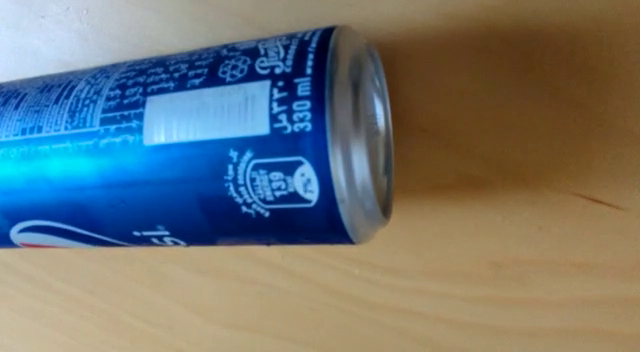

In [4]:
trash = list(data_dir.glob('Can/*'))
PIL.Image.open(str(trash[0]))

In [6]:
batch_size = 32
image_height = 456 #to suit EfficientNetB5
image_width = 456

In [7]:
# with tf.device('/CPU:0'):
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.1,
  subset="training",
  seed=123,
  image_size=(image_height, image_width),
  batch_size=batch_size)

Found 62651 files belonging to 3 classes.
Using 56386 files for training.


In [8]:

val_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(image_height, image_width),
    batch_size=batch_size)

Found 62651 files belonging to 3 classes.
Using 12530 files for validation.


In [9]:

test_dir = pathlib.Path("data-camera-rpi")
test_ds = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    seed=123,
    image_size=(image_height, image_width),
    batch_size=batch_size)

Found 96 files belonging to 3 classes.


In [8]:
# Don't run this cell if you are testing on a new dataset
val_batches = tf.data.experimental.cardinality(val_ds)
test_ds = val_ds.take(val_batches // 2)
val_ds = val_ds.skip(val_batches // 2)

In [ ]:
print('Number of validation batches: %d' % tf.data.experimental.cardinality(val_ds))
# print('Number of test batches: %d' % tf.data.experimental.cardinality(test_ds))

Number of validation batches: 132


In [10]:
#Possible Resizing
IMG_SIZE=456
size = (IMG_SIZE, IMG_SIZE)
train_ds = train_ds.map(lambda image, label: (tf.image.resize(image, size), label))
# val_ds = val_ds.map(lambda image, label: (tf.image.resize(image, size), label))
test_ds = test_ds.map(lambda image, label: (tf.image.resize(image, size), label))


Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


In [31]:
#Classes as inferred
class_names = train_ds.class_names
print(class_names)

AttributeError: 'PrefetchDataset' object has no attribute 'class_names'

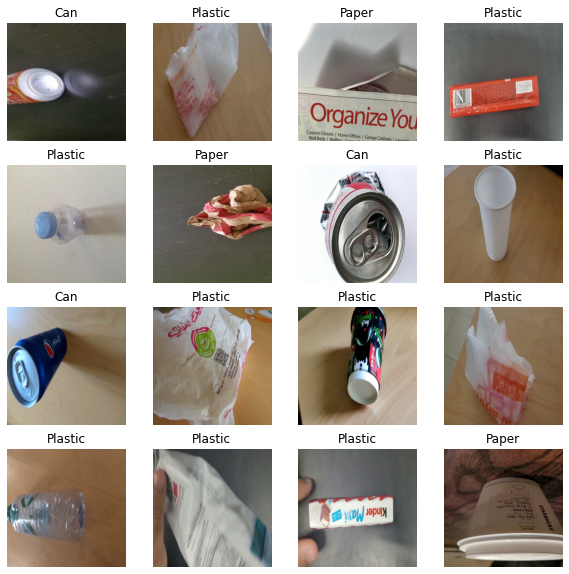

In [18]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(16):
    ax = plt.subplot(4, 4, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [9]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 456, 456, 3)
(32,)


# **Configure Dataset Performance**

In [11]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)
test_ds= test_ds.prefetch(buffer_size=AUTOTUNE)

# **Data Augmentation**

In [26]:
# Improved data augmentation - don't execute
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomRotation(factor=0.15),
  tf.keras.layers.RandomTranslation(height_factor=0.1, width_factor=0.1),
  tf.keras.layers.RandomFlip(),
  tf.keras.layers.RandomZoom(0.2),
  tf.keras.layers.RandomContrast(factor=0.1)
])

In [ ]:
#verify data augmentation - don't execute 
for image, label in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        aug_img = data_augmentation(tf.expand_dims(image,axis=1))
        plt.imshow(aug_img[0].numpy().astype("uint8"))
        plt.title("{}".format(format_label(label)))
        plt.axis("off")


#Load The Pre-trained Model - EfficientNetB5

In [12]:
#importing VGG16
from tensorflow.keras.applications import EfficientNetB5
#from tensorflow.keras.applications import preprocess_input

In [13]:
base_model = EfficientNetB5(
    include_top=False,
    weights='imagenet',
    input_tensor=None,
    input_shape=(image_height,image_width,3),
    pooling=None,
    classes=1000,
    classifier_activation='softmax',
    drop_connect_rate=0.4
)
#Don't train existing weights
base_model.trainable = False 

In [33]:
base_model.summary()

Model: "efficientnetb5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 456, 456, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 456, 456, 3)  0           ['input_1[0][0]']                
                                                                                                  
 normalization (Normalization)  (None, 456, 456, 3)  7           ['rescaling[0][0]']              
                                                                                                  
 rescaling_1 (Rescaling)        (None, 456, 456, 3)  0           ['normalization[0][0

In [16]:
def plot_hist(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    plt.figure(figsize=(8, 8))
    plt.subplot(2, 1, 1)
    plt.plot(acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.ylabel('Accuracy')
    plt.ylim([min(plt.ylim()),1])
    plt.title('Training and Validation Accuracy')

    plt.subplot(2, 1, 2)
    plt.plot(loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.ylabel('Cross Entropy')
    plt.ylim([0,1.0])
    plt.title('Training and Validation Loss')
    plt.xlabel('epoch')
    plt.show()

Transfer Learning with Pretrained Weights

In [17]:
inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
model = EfficientNetB5(include_top=False, input_tensor=inputs, weights="imagenet")

    # Freeze the pretrained weights
model.trainable = False

    # Rebuild top
x = layers.GlobalAveragePooling2D(name="avg_pool")(model.output)
x = layers.BatchNormalization()(x)

top_dropout_rate = 0.2
x = layers.Dropout(top_dropout_rate, name="top_dropout")(x)
outputs = layers.Dense(3, activation="softmax", name="pred")(x)

    # Compile
model = tf.keras.Model(inputs, outputs, name="EfficientNet")
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-2)
model.compile(optimizer=optimizer, loss=tf.keras.losses.SparseCategoricalCrossentropy(), metrics=["accuracy"])

In [18]:
epochs = 25  # @param {type: "slider", min:8, max:80}
hist = model.fit(train_ds, epochs=epochs, validation_data=val_ds, verbose=2)

Epoch 1/25
1763/1763 - 1101s - loss: 0.3739 - accuracy: 0.9557 - val_loss: 0.0641 - val_accuracy: 0.9923 - 1101s/epoch - 625ms/step
Epoch 2/25
1763/1763 - 1091s - loss: 0.3763 - accuracy: 0.9685 - val_loss: 0.1219 - val_accuracy: 0.9854 - 1091s/epoch - 619ms/step
Epoch 3/25
1763/1763 - 1089s - loss: 0.3578 - accuracy: 0.9725 - val_loss: 0.0583 - val_accuracy: 0.9944 - 1089s/epoch - 618ms/step
Epoch 4/25
1763/1763 - 1089s - loss: 0.3320 - accuracy: 0.9750 - val_loss: 0.0416 - val_accuracy: 0.9959 - 1089s/epoch - 618ms/step
Epoch 5/25
1763/1763 - 1089s - loss: 0.4046 - accuracy: 0.9717 - val_loss: 0.1008 - val_accuracy: 0.9923 - 1089s/epoch - 618ms/step
Epoch 6/25
1763/1763 - 1089s - loss: 0.3872 - accuracy: 0.9734 - val_loss: 0.0436 - val_accuracy: 0.9962 - 1089s/epoch - 617ms/step
Epoch 7/25
1763/1763 - 1089s - loss: 0.3839 - accuracy: 0.9741 - val_loss: 0.1268 - val_accuracy: 0.9927 - 1089s/epoch - 617ms/step
Epoch 8/25
1763/1763 - 1089s - loss: 0.4243 - accuracy: 0.9734 - val_loss: 0

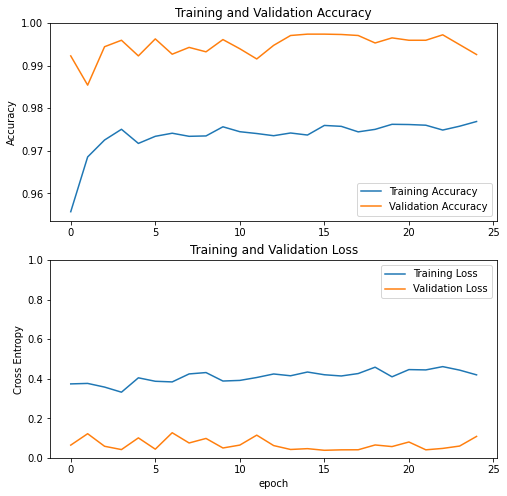

In [19]:
plot_hist(hist)

**Fine-Turning**


In [20]:
for layer in model.layers[-20:]:
        if not isinstance(layer, layers.BatchNormalization):
            layer.trainable = True
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
model.compile(optimizer=optimizer, loss=tf.keras.losses.SparseCategoricalCrossentropy(), metrics=["accuracy"])


In [21]:
log_dir = "logs/" + "EffcientNetB5-STBv1.1"

# create a TensorBoard callback to visualize training metrics
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

In [22]:
epochs = 10  # @param {type: "slider", min:8, max:50}
hist = model.fit(train_ds, epochs=epochs, validation_data=val_ds, verbose=2,callbacks=[tensorboard_callback])

Epoch 1/10
1763/1763 - 1131s - loss: 0.2290 - accuracy: 0.9874 - val_loss: 0.0200 - val_accuracy: 0.9991 - 1131s/epoch - 641ms/step
Epoch 2/10
1763/1763 - 1123s - loss: 0.1099 - accuracy: 0.9939 - val_loss: 0.0095 - val_accuracy: 0.9998 - 1123s/epoch - 637ms/step
Epoch 3/10
1763/1763 - 1124s - loss: 0.0760 - accuracy: 0.9958 - val_loss: 0.0031 - val_accuracy: 0.9999 - 1124s/epoch - 637ms/step
Epoch 4/10
1763/1763 - 1124s - loss: 0.0537 - accuracy: 0.9968 - val_loss: 1.6739e-04 - val_accuracy: 0.9999 - 1124s/epoch - 638ms/step
Epoch 5/10
1763/1763 - 1123s - loss: 0.0407 - accuracy: 0.9977 - val_loss: 0.0011 - val_accuracy: 0.9999 - 1123s/epoch - 637ms/step
Epoch 6/10
1763/1763 - 1123s - loss: 0.0561 - accuracy: 0.9972 - val_loss: 0.0052 - val_accuracy: 0.9998 - 1123s/epoch - 637ms/step
Epoch 7/10
1763/1763 - 1124s - loss: 0.0286 - accuracy: 0.9984 - val_loss: 0.0078 - val_accuracy: 0.9998 - 1124s/epoch - 637ms/step
Epoch 8/10
1763/1763 - 1124s - loss: 0.0353 - accuracy: 0.9980 - val_los

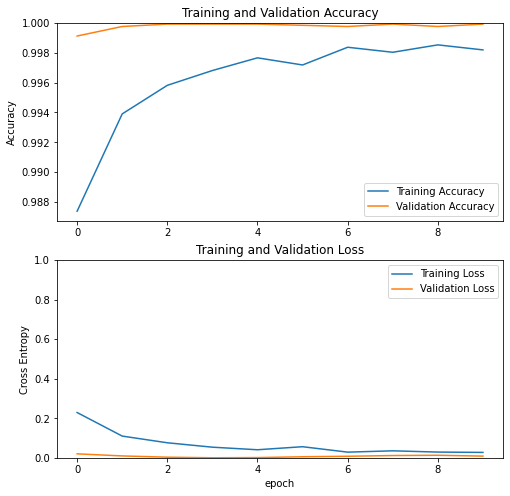

In [23]:
plot_hist(hist)

In [24]:
loss, accuracy = model.evaluate(test_ds)
print('Test accuracy :', accuracy)

3/3 [==============================] - 1s 464ms/step - loss: 6.4254 - accuracy: 0.8958
Test accuracy : 0.8958333134651184


In [ ]:
# Import a function from sklearn to calculate the confusion-matrix.
from sklearn.metrics import confusion_matrix

def print_confusion_matrix(cls_pred):
    # cls_pred is an array of the predicted class-number for
    # all images in the test-set.

    # Get the confusion matrix using sklearn.
    cm = confusion_matrix(y_true=cls_test,  # True class for test-set.
                          y_pred=cls_pred)  # Predicted class.

    print("Confusion matrix:")
    
    # Print the confusion matrix as text.
    print(cm)
    
    # Print the class-names for easy reference.
    for i, class_name in enumerate(class_names):
        print("({0}) {1}".format(i, class_name))

# **Evaluation and Prediction**

In [ ]:
# No need to do this if u just trained the model from above
# load trained model
l_model = tf.keras.models.load_model("/content/drive/My Drive/Models/VGG16-STBv1.2")
l_model.summary()

In [29]:
# Evaluating on a new dataset from the internet
# paper and plastic from  https://www.kaggle.com/datasets/arthurcen/waste-images-from-sushi-restaurant
# can from https://universe.roboflow.com/dataset-t7hz7/cans-fdboa/dataset/1
test_dir = pathlib.Path("Dataset-testing (from internet)")

batch_size = 32
image_height = 224
image_width = 224

test_ds = tf.keras.utils.image_dataset_from_directory(
  test_dir,
  seed=123,
  image_size=(image_height, image_width),
  batch_size=batch_size)


Found 699 files belonging to 3 classes.


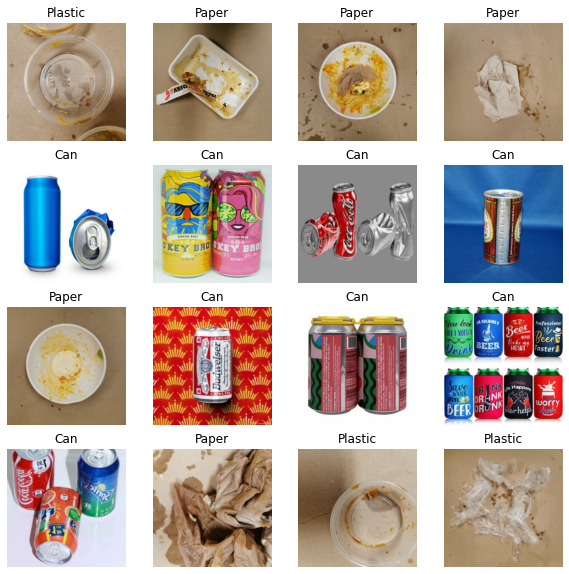

In [ ]:
plt.figure(figsize=(10, 10))
for images, labels in test_ds.take(1):
  for i in range(16):
    ax = plt.subplot(4, 4, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(test_ds.class_names[labels[i]])
    plt.axis("off")

In [30]:
loss, accuracy = model.evaluate(test_ds)
print('Test accuracy :', accuracy)

22/22 [==============================] - 6s 146ms/step - loss: 29.7846 - accuracy: 0.6481
Test accuracy : 0.6480686664581299


In [ ]:
# Retrieve a batch of images from the test set
# Not complete
image_batch, label_batch = test_ds.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch).flatten()

score = tf.nn.softmax(predictions[0])

print('Predictions:\n', predictions.numpy())
print('Labels:\n', label_batch)

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)


## Saving Model 

In [26]:
#code for saving model 
model.save("Models/EfficientNetB5-STBv1.2")

INFO:tensorflow:Assets written to: Models/EfficientNetB5-STBv1.2/assets


INFO:tensorflow:Assets written to: Models/EfficientNetB5-STBv1.2/assets


TypeError: Unable to serialize [2.0896919 2.1128857 2.1081853] to JSON. Unrecognized type <class 'tensorflow.python.framework.ops.EagerTensor'>.

# **Loading The Model**

In [26]:
model = tf.keras.models.load_model("Models/EfficientNetB5-STBv1.1")

# Check its architecture
model.summary()

ValueError: Unable to create a Keras model from SavedModel at Models/EfficientNetB5-STBv1.1. This SavedModel was exported with `tf.saved_model.save`, and lacks the Keras metadata file. Please save your Keras model by calling `model.save` or `tf.keras.models.save_model`. Note that you can still load this SavedModel with `tf.saved_model.load`.

In [2]:
import tensorflow as tf
tf.__version__

'2.11.0'

# **Converting The Model to Lite**

In [ ]:
# Convert the model.
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the model.
with open('/content/drive/My Drive/Models/VGG16-STBv1.2Lite', 'wb') as f:
  f.write(tflite_model)

In [ ]:
l_model = keras.models.load_model('/content/drive/MyDrive/Models/model3')

# Convert the model.
converter = tf.lite.TFLiteConverter.from_keras_model(l_model)
tflite_model = converter.convert()

# Save the model.
with open('/content/drive/MyDrive/Models/model.tflite', 'wb') as f:
  f.write(tflite_model)

In [ ]:
l_model = keras.models.load_model('/content/drive/MyDrive/Models/VGG16-STBv1.2')

In [ ]:
l_model.summary()